In [1]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,Permute,AveragePooling2D
from keras.layers import Conv1D,Conv2D,BatchNormalization,MaxPooling1D,MaxPooling2D,Reshape,LSTM,TimeDistributed
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Use GPU

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [3]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Printing the shapes of the numpy arrays

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


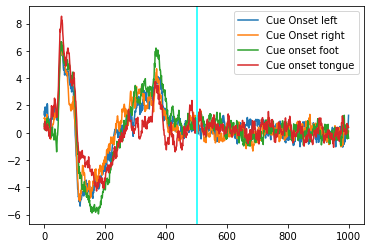

In [4]:
for i in range(len(y_train_valid)):
    y_train_valid[i] -= 769
for i in range(len(y_test)):
    y_test[i] -=769
## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)



# plt.plot(np.arange(1000),avg_ch_data_class_0)
# plt.plot(np.arange(1000),avg_ch_data_class_1)
# plt.plot(np.arange(1000),avg_ch_data_class_2)
# plt.plot(np.arange(1000),avg_ch_data_class_3)


# plt.axvline(x=500, label='line at t=500',c='cyan')

# plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])
       

In [5]:
def data_prep(X,y,person,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    total_person = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
#     print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    total_person = person
#     print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
#     print('Shape of y before averaging+noise and concatenating:',total_y.shape)
#     print('Shape of person before averaging+noise and concatenating:',total_person.shape)
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_person = np.vstack((total_person, person))
#     print('Shape of X after averaging+noise and concatenating:',total_X.shape)
#     print('Shape of y after averaging+noise and concatenating:',total_y.shape)
#     print('Shape of person after averaging+noise and concatenating:',total_person.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_person = np.vstack((total_person, person))
        
    
#     print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y,total_person


X_train_valid_prep,y_train_valid_prep,person_train_valid_pred = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)


In [6]:
## Preprocessing the dataset

print(X_test.shape)
print(y_test.shape)
print(person_test.shape)

X_train_valid_prep,y_train_valid_prep,_ = data_prep(X_train_valid,y_train_valid,person_train_valid,2,2,True)
X_test_prep,y_test_prep,person_test_prep = data_prep(X_test,y_test,person_test,2,2,True)

print("--------------------------------------------------")
print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
# print(person_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)
print(person_test_prep.shape)



## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(8460, 1500, replace=False)
ind_train = np.array(list(set(range(8460)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid_prep[ind_train], X_train_valid_prep[ind_valid] 
(y_train, y_valid) = y_train_valid_prep[ind_train], y_train_valid_prep[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


(443, 22, 1000)
(443,)
(443, 1)
--------------------------------------------------
(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)
(1772, 1)
Shape of training set: (6960, 22, 250)
Shape of validation set: (1500, 22, 250)
Shape of training labels: (6960,)
Shape of validation labels: (1500,)
Shape of training labels after categorical conversion: (6960, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (1772, 4)
Shape of training set after adding width info: (6960, 22, 250, 1)
Shape of validation set after adding width info: (1500, 22, 250, 1)
Shape of test set after adding width info: (1772, 22, 250, 1)
Shape of training set after dimension reshaping: (6960, 250, 1, 22)
Shape of validation set after dimension reshaping: (1500, 250, 1, 22)
Shape of test set after dimension reshaping: (1772, 250, 1, 22)


In [7]:
# Building the CNN model using sequential class
cnn_model = Sequential()
# Spatial Convolution
cnn_model.add(Conv2D(filters=25,kernel_size=(10,1),padding='same',activation= 'relu', input_shape=(250,1,22)) )
# Max Pooling and  Batch Normalization
cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
#CNN2
cnn_model.add(Conv2D(filters=50,kernel_size=(10,1),padding='same',activation= 'relu'))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same')) 
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))
#CNN3
cnn_model.add(Conv2D(filters=100,kernel_size=(10,1),padding='same',activation= 'relu'))
cnn_model.add(AveragePooling2D(pool_size=(3,1), padding='same')) 
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

#LSTM 1
cnn_model.add(Flatten())
cnn_model.add(Dense((50)))
cnn_model.add(Reshape((50,1)))
cnn_model.add(LSTM(10,dropout=0.5, recurrent_dropout=0.5, input_shape=(50,1),return_sequences = False))


cnn_model.add(Dense(4, activation = 'softmax'))
# Printing the model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 25)        5525      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 25)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 25)        100       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 25)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 50)         12550     
                                                                 
 average_pooling2d (AverageP  (None, 28, 1, 50)        0

In [8]:
learning_rate = 0.001
epochs = 200
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate)

## Metrics: Precision, Recall, F1

In [9]:
# Reference: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy',f1_m,precision_m, recall_m])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)



Epoch 1/200
109/109 [==============================] - 9s 60ms/step - loss: 1.3480 - accuracy: 0.3263 - f1_m: 0.0384 - precision_m: 0.3575 - recall_m: 0.0208 - val_loss: 1.2843 - val_accuracy: 0.3987 - val_f1_m: 0.0675 - val_precision_m: 0.7052 - val_recall_m: 0.0358
Epoch 2/200
109/109 [==============================] - 6s 57ms/step - loss: 1.2738 - accuracy: 0.3852 - f1_m: 0.1905 - precision_m: 0.6449 - recall_m: 0.1141 - val_loss: 1.2363 - val_accuracy: 0.4027 - val_f1_m: 0.2237 - val_precision_m: 0.6237 - val_recall_m: 0.1373
Epoch 3/200
109/109 [==============================] - 7s 63ms/step - loss: 1.2303 - accuracy: 0.4195 - f1_m: 0.2338 - precision_m: 0.6746 - recall_m: 0.1432 - val_loss: 1.1592 - val_accuracy: 0.4567 - val_f1_m: 0.2706 - val_precision_m: 0.6945 - val_recall_m: 0.1695
Epoch 4/200
109/109 [==============================] - 9s 81ms/step - loss: 1.1900 - accuracy: 0.4422 - f1_m: 0.2521 - precision_m: 0.6918 - recall_m: 0.1558 - val_loss: 1.1331 - val_accuracy: 0.4

109/109 [==============================] - 7s 63ms/step - loss: 0.4192 - accuracy: 0.8517 - f1_m: 0.8512 - precision_m: 0.8720 - recall_m: 0.8317 - val_loss: 0.2033 - val_accuracy: 0.9280 - val_f1_m: 0.9311 - val_precision_m: 0.9368 - val_recall_m: 0.9256
Epoch 62/200
109/109 [==============================] - 7s 61ms/step - loss: 0.3962 - accuracy: 0.8543 - f1_m: 0.8542 - precision_m: 0.8741 - recall_m: 0.8355 - val_loss: 0.2251 - val_accuracy: 0.9167 - val_f1_m: 0.9186 - val_precision_m: 0.9237 - val_recall_m: 0.9137
Epoch 63/200
109/109 [==============================] - 7s 65ms/step - loss: 0.4244 - accuracy: 0.8486 - f1_m: 0.8467 - precision_m: 0.8641 - recall_m: 0.8302 - val_loss: 0.2053 - val_accuracy: 0.9300 - val_f1_m: 0.9331 - val_precision_m: 0.9387 - val_recall_m: 0.9277
Epoch 64/200
109/109 [==============================] - 7s 60ms/step - loss: 0.3945 - accuracy: 0.8573 - f1_m: 0.8571 - precision_m: 0.8745 - recall_m: 0.8407 - val_loss: 0.2330 - val_accuracy: 0.9193 - val

109/109 [==============================] - 7s 62ms/step - loss: 0.2902 - accuracy: 0.8945 - f1_m: 0.8950 - precision_m: 0.9045 - recall_m: 0.8858 - val_loss: 0.1262 - val_accuracy: 0.9567 - val_f1_m: 0.9589 - val_precision_m: 0.9608 - val_recall_m: 0.9570
Epoch 122/200
109/109 [==============================] - 7s 62ms/step - loss: 0.3056 - accuracy: 0.8928 - f1_m: 0.8929 - precision_m: 0.9033 - recall_m: 0.8829 - val_loss: 0.0839 - val_accuracy: 0.9733 - val_f1_m: 0.9722 - val_precision_m: 0.9751 - val_recall_m: 0.9694
Epoch 123/200
109/109 [==============================] - 7s 62ms/step - loss: 0.2994 - accuracy: 0.8922 - f1_m: 0.8925 - precision_m: 0.9027 - recall_m: 0.8826 - val_loss: 0.0864 - val_accuracy: 0.9713 - val_f1_m: 0.9716 - val_precision_m: 0.9732 - val_recall_m: 0.9701
Epoch 124/200
109/109 [==============================] - 7s 60ms/step - loss: 0.2972 - accuracy: 0.8967 - f1_m: 0.8948 - precision_m: 0.9059 - recall_m: 0.8843 - val_loss: 0.0957 - val_accuracy: 0.9700 - 

109/109 [==============================] - 7s 62ms/step - loss: 0.2571 - accuracy: 0.9108 - f1_m: 0.9120 - precision_m: 0.9199 - recall_m: 0.9043 - val_loss: 0.0631 - val_accuracy: 0.9793 - val_f1_m: 0.9795 - val_precision_m: 0.9804 - val_recall_m: 0.9785
Epoch 182/200
109/109 [==============================] - 7s 62ms/step - loss: 0.2574 - accuracy: 0.9111 - f1_m: 0.9106 - precision_m: 0.9187 - recall_m: 0.9028 - val_loss: 0.0555 - val_accuracy: 0.9873 - val_f1_m: 0.9869 - val_precision_m: 0.9882 - val_recall_m: 0.9857
Epoch 183/200
109/109 [==============================] - 7s 60ms/step - loss: 0.2451 - accuracy: 0.9157 - f1_m: 0.9149 - precision_m: 0.9245 - recall_m: 0.9056 - val_loss: 0.0440 - val_accuracy: 0.9900 - val_f1_m: 0.9912 - val_precision_m: 0.9922 - val_recall_m: 0.9902
Epoch 184/200
109/109 [==============================] - 7s 62ms/step - loss: 0.2465 - accuracy: 0.9116 - f1_m: 0.9115 - precision_m: 0.9200 - recall_m: 0.9032 - val_loss: 0.0550 - val_accuracy: 0.9887 - 

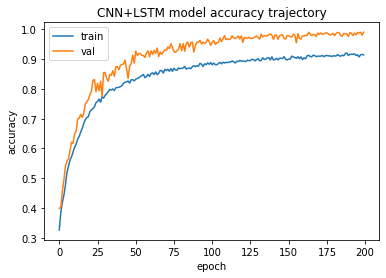

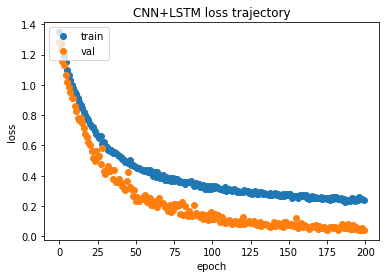

In [11]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN+LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN+LSTM loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [12]:
cnn_score = cnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.7138826251029968


In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

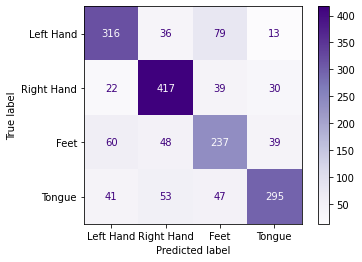

In [14]:
y_true = np.argmax(y_test,axis=1)
y_pred = np.argmax(cnn_model.predict(x_test),axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left Hand','Right Hand','Feet','Tongue'])
disp.plot(cmap=plt.cm.Purples)
plt.show()

In [15]:
# print(person_test.shape)
# print(person_test_prep.shape)
# print(person_test_prep)
idx_sub1 = np.where(person_test_prep==0)[0]
idx_sub2 = np.where(person_test_prep==1)[0]
idx_sub3 = np.where(person_test_prep==2)[0]
idx_sub4 = np.where(person_test_prep==3)[0]
idx_sub5 = np.where(person_test_prep==4)[0]
idx_sub6 = np.where(person_test_prep==5)[0]
idx_sub7 = np.where(person_test_prep==6)[0]
idx_sub8 = np.where(person_test_prep==7)[0]
idx_sub9 = np.where(person_test_prep==8)[0]

In [23]:
score1 = cnn_model.evaluate(x_test[idx_sub1], y_test[idx_sub1], verbose=0)
score2 = cnn_model.evaluate(x_test[idx_sub2], y_test[idx_sub2], verbose=0)
score3 = cnn_model.evaluate(x_test[idx_sub3], y_test[idx_sub3], verbose=0)
score4 = cnn_model.evaluate(x_test[idx_sub4], y_test[idx_sub4], verbose=0)
score5 = cnn_model.evaluate(x_test[idx_sub5], y_test[idx_sub5], verbose=0)
score6 = cnn_model.evaluate(x_test[idx_sub6], y_test[idx_sub6], verbose=0)
score7 = cnn_model.evaluate(x_test[idx_sub7], y_test[idx_sub7], verbose=0)
score8 = cnn_model.evaluate(x_test[idx_sub8], y_test[idx_sub8], verbose=0)
score9 = cnn_model.evaluate(x_test[idx_sub9], y_test[idx_sub9], verbose=0)

print('Subject | Test Accuracy | Precision |  Recall  |   F1')
print('1       | ', "{:.4f}".format(score1[1]), '      | ', "{:.4f}".format(score1[2]), '  | ', "{:.4f}".format(score1[3]), ' | ', "{:.4f}".format(score1[4]))
print('2       | ', "{:.4f}".format(score2[1]), '      | ', "{:.4f}".format(score2[2]), '  | ', "{:.4f}".format(score2[3]), ' | ', "{:.4f}".format(score2[4]))
print('3       | ', "{:.4f}".format(score3[1]), '      | ', "{:.4f}".format(score3[2]), '  | ', "{:.4f}".format(score3[3]), ' | ', "{:.4f}".format(score3[4]))
print('4       | ', "{:.4f}".format(score4[1]), '      | ', "{:.4f}".format(score4[2]), '  | ', "{:.4f}".format(score4[3]), ' | ', "{:.4f}".format(score4[4]))
print('5       | ', "{:.4f}".format(score5[1]), '      | ', "{:.4f}".format(score5[2]), '  | ', "{:.4f}".format(score5[3]), ' | ', "{:.4f}".format(score5[4]))
print('6       | ', "{:.4f}".format(score6[1]), '      | ', "{:.4f}".format(score6[2]), '  | ', "{:.4f}".format(score6[3]), ' | ', "{:.4f}".format(score6[4]))
print('7       | ', "{:.4f}".format(score7[1]), '      | ', "{:.4f}".format(score7[2]), '  | ', "{:.4f}".format(score7[3]), ' | ', "{:.4f}".format(score7[4]))
print('8       | ', "{:.4f}".format(score8[1]), '      | ', "{:.4f}".format(score8[2]), '  | ', "{:.4f}".format(score8[3]), ' | ', "{:.4f}".format(score8[4]))
print('9       | ', "{:.4f}".format(score9[1]), '      | ', "{:.4f}".format(score9[2]), '  | ', "{:.4f}".format(score9[3]), ' | ', "{:.4f}".format(score9[4]))

Subject | Test Accuracy | Precision |  Recall  |   F1
1       |  0.6450       |  0.6439   |  0.6597  |  0.6295
2       |  0.6150       |  0.6376   |  0.6461  |  0.6295
3       |  0.7450       |  0.7559   |  0.7675  |  0.7455
4       |  0.6400       |  0.6759   |  0.6977  |  0.6562
5       |  0.7766       |  0.7762   |  0.7803  |  0.7723
6       |  0.7143       |  0.7251   |  0.7318  |  0.7188
7       |  0.7700       |  0.7763   |  0.7952  |  0.7589
8       |  0.7150       |  0.7309   |  0.7390  |  0.7232
9       |  0.8138       |  0.8246   |  0.8332  |  0.8162


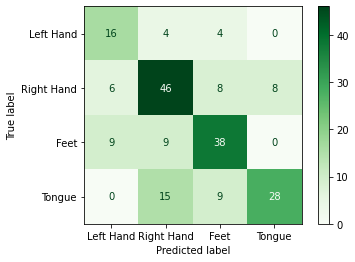

In [17]:
# Confusion matric for subject 7
y_true7 = np.argmax(y_test[idx_sub4],axis=1)
y_pred7 = np.argmax(cnn_model.predict(x_test[idx_sub4]),axis=1)
cm7 = confusion_matrix(y_true7, y_pred7)
disp7 = ConfusionMatrixDisplay(confusion_matrix=cm7, display_labels=['Left Hand','Right Hand','Feet','Tongue'])
disp7.plot(cmap=plt.cm.Greens)
plt.show()